# Easysnowdata

[easysnowdata](https://egagli.github.io/easysnowdata/) is a collection of scripts to access and process cloud hosted remote sensing datasets. It is designed for snow and glacier applications. However, it allows accessing cloud-hosted datasets, such as the Harmonized Landsat-Sentinel (HLS) dataset, which can be used in the context of tracking reservoirs and lakes.

In [1]:
# import dask
# from dask.distributed import LocalCluster, Client

In [2]:
# cluster = LocalCluster(n_workers=12, threads_per_worker=1)
# client = Client(cluster)
# client

## Sentinel-2 data

In [22]:
s2 = esd.remote_sensing.Sentinel2(
    bbox_input=buffered_roi,
    start_date="2022-07-01",
    end_date="2022-07-31",
    catalog_choice="planetarycomputer",
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 46N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data acquired after January 25th, 2022 harmonized to old baseline. To turn this behavior off, set harmonize_to_old=False.
Data scaled to reflectance. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute.


In [23]:
s2.data

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 2336, x: 1948, time: 12)
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
    spatial_ref  int32 4B 32646
  * time         (time) datetime64[ns] 96B 2022-07-02T04:16:01.024000 ... 202...
Data variables: (12/16)
    coastal      (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    blue         (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    green        (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    red          (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    rededge      (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    rededge2     (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    swir22       (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    aot          (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    scl          (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    wvp          (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
    visual       (time, y, x) float32 218MB dask.array<chunksize=(1, 2336, 1948), meta=np.ndarray>
Attributes:
    band_info:       {'B01': {'name': 'coastal', 'description': 'Coastal aero...
    scl_class_info:  {0: {'name': 'No Data (Missing data)', 'color': '#000000...

In [24]:
s2.mask_data()

Removed pixels with the following scene classification values:
No Data (Missing data)
Saturated or defective pixel
Topographic casted shadows
Cloud shadows
Cloud medium probability
Cloud high probability
Thin cirrus


In [25]:
s2.get_ndwi()
s2.ndwi

NDWI data calculated. Access with the .ndwi attribute.


<xarray.DataArray (time: 12, y: 2336, x: 1948)> Size: 218MB
dask.array<truediv, shape=(12, 2336, 1948), dtype=float32, chunksize=(1, 2336, 1948), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
    spatial_ref  int32 4B 32646
  * time         (time) datetime64[ns] 96B 2022-07-02T04:16:01.024000 ... 202...

In [26]:
ndwi = s2.ndwi.compute()

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


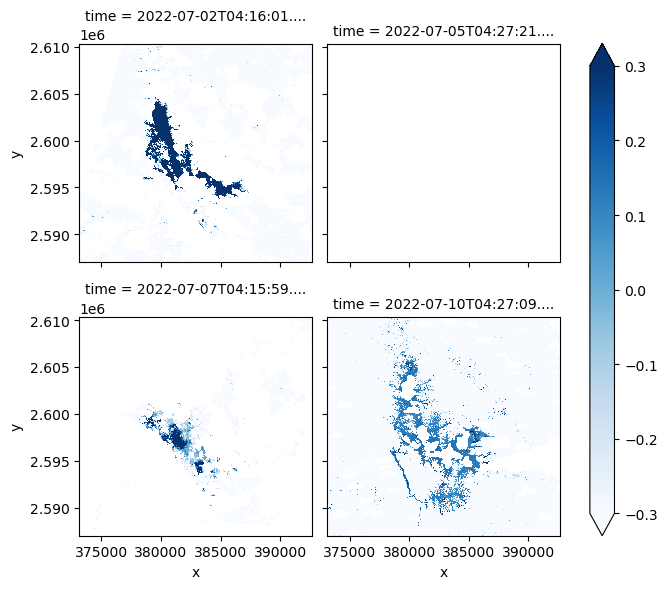

In [19]:
im = ndwi.isel(time=slice(4)).plot.imshow(
    col="time", col_wrap=2, 
    cmap="Blues", robust=True,
    vmax=0.3
)

## HLS (Harmonized Landsat-Sentinel) data

In [4]:
# import earthaccess
# earthaccess.login(persist=True)

In [5]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

dumboor_pt = val_pts.loc[val_pts['tmsos_id']=='0505']
dumboor_poly = val_polys.loc[val_polys['tmsos_id']=='0505']

# shapely geom
buffered_roi = dumboor_poly.geometry.iloc[0].convex_hull.buffer(0.05)
bbox = buffered_roi.bounds
# buffered_roi

# geodataframe
dumboor_buffered = dumboor_poly.buffer(0.05)
dumboor_buffered

/tmp/ipykernel_4071910/1417383607.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dumboor_buffered = dumboor_poly.buffer(0.05)


82    POLYGON ((91.76158 23.47984, 91.76068 23.48246...
dtype: geometry

In [6]:
# import easysnowdata
import geopandas as gpd
from pathlib import Path
import easysnowdata

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

dumboor_pt = val_pts.loc[val_pts['tmsos_id']=='0505']
dumboor_poly = val_polys.loc[val_polys['tmsos_id']=='0505']

# shapely geom
buffered_roi = dumboor_poly.geometry.iloc[0].convex_hull.buffer(0.05)
bbox = buffered_roi.bounds
# buffered_roi

# geodataframe
dumboor_buffered = dumboor_poly.buffer(0.05)

hls = easysnowdata.remote_sensing.HLS(
    bbox_input=buffered_roi, start_date="2022-07-01", end_date="2022-07-31"
)

hls.data

/tmp/ipykernel_4071910/746493213.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dumboor_buffered = dumboor_poly.buffer(0.05)


Data searched. Access the returned seach with the .search_landsat or .search_sentinel attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 46N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data scaled to reflectance. Access with the .data attribute. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute. To turn this behavior off, set add_metadata=False.
Platform, geometry, cloud cover, browse URLs added to data as coordinates. Access with the .data attribute. To turn this behavior off, set add_platform=False.


<xarray.Dataset> Size: 567MB
Dimensions:                    (y: 779, x: 650, time: 14)
Coordinates:
  * y                          (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                          (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...
Data variables: (12/20)
    coastal aerosol            (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    blue                       (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    green                      (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red                        (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nir narrow                 (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    swir 1                     (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ...                         ...
    VAA                        (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red-edge 1                 (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    red-edge 2                 (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    red-edge 3                 (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    nir broad                  (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    water vapor                (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>

In [14]:
# hls.get_data()
# hls.data

In [15]:
# hls_data = hls.data.compute()

In [16]:
# hls.get_rgb()
# hls.rgb

In [17]:
hls.mask_data()

Data masked. Using Fmask, removed pixels classified as:
Cirrus
Cloud
Adjacent to cloud / shadow
Cloud shadows


In [18]:
hls.get_ndwi()
hls.ndwi

NDWI data calculated. Access with the .ndwi attribute.


<xarray.DataArray (time: 14, y: 779, x: 650)> Size: 28MB
dask.array<truediv, shape=(14, 779, 650), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                          (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                          (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 54.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022184T041829.v2.0/HLS.L30.T46QCM.2022184T041829.v2.0.Fmask.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022183T041601.v2.0/HLS.S30.T46QCM.2022183T041601.v2.0.B03.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022201T042709.v2.0/HLS.S30.T46QCM.2022201T042709.v2.0.Fmask.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022201T042709.v2.0/HLS.S30.T46QCM.2022201T042709.v2.0.B8A.

KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCL.2022184T041853.v2.0/HLS.L30.T46QCL.2022184T041853.v2.0.Fmask.tif:1


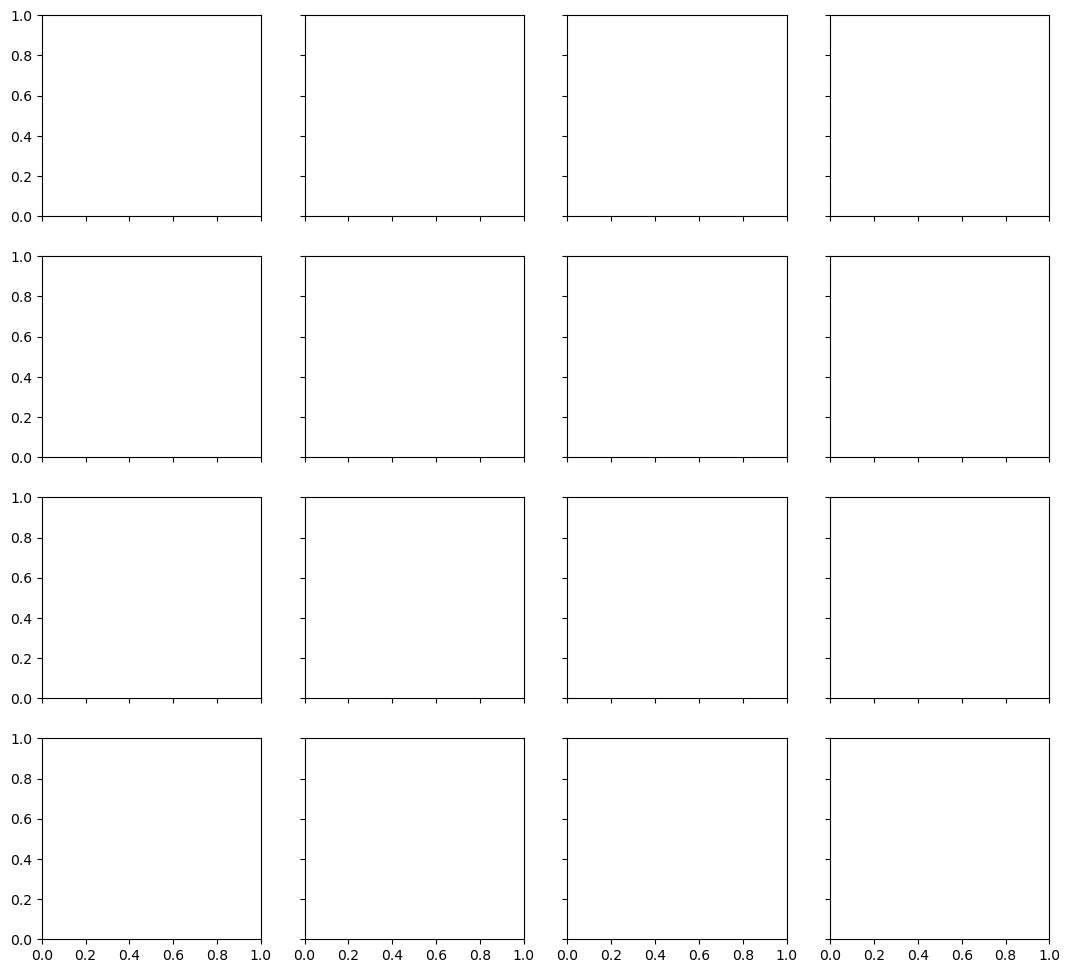

Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCL.2022183T041601.v2.0/HLS.S30.T46QCL.2022183T041601.v2.0.B03.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022201T042709.v2.0/HLS.S30.T46QCM.2022201T042709.v2.0.B8A.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022201T042709.v2.0/HLS.S30.T46QCM.2022201T042709.v2.0.B03.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCL.2022183T041601.v2.0/HLS.S30.T46QCL.2022183T041601.v2.0.Fmask.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022183T041601.v2.0/HLS.S30.T46QCM.2022183T041601.v2.0.Fmask.tif:1
Ignoring read failure while reading: https://d

In [19]:
from matplotlib import pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(10, 10))

f = hls.ndwi.plot.imshow(col='time',col_wrap=4,robust=True, cmap='RdYlBu', vmax=0.3)

for ax, time, platform in zip(f.axes.flat, hls.ndwi.time.values, hls.ndwi.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

## Harmonized Landsat Sentinel-2 v2.0

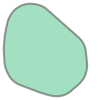

In [6]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

dumboor_pt = val_pts.loc[val_pts['tmsos_id']=='0505']
dumboor_poly = val_polys.loc[val_polys['tmsos_id']=='0505']

buffered_roi = dumboor_poly.geometry.iloc[0].convex_hull.buffer(0.05)
bbox = buffered_roi.bounds
buffered_roi

In [8]:
import easysnowdata

hls = easysnowdata.remote_sensing.HLS(
    bbox_input=buffered_roi, start_date="2022-07-01", end_date="2022-07-31",
)

Data searched. Access the returned seach with the .search_landsat or .search_sentinel attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 46N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data scaled to reflectance. Access with the .data attribute. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute. To turn this behavior off, set add_metadata=False.
Platform, geometry, cloud cover, browse URLs added to data as coordinates. Access with the .data attribute. To turn this behavior off, set add_platform=False.


In [9]:
hls.data

<xarray.Dataset> Size: 567MB
Dimensions:                    (y: 779, x: 650, time: 14)
Coordinates:
  * y                          (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                          (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...
Data variables: (12/20)
    coastal aerosol            (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    blue                       (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    green                      (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red                        (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nir narrow                 (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    swir 1                     (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ...                         ...
    VAA                        (time, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red-edge 1                 (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    red-edge 2                 (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    red-edge 3                 (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    nir broad                  (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    water vapor                (time, y, x) float32 28MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>

In [10]:
hls.data.platform

<xarray.DataArray 'platform' (time: 14)> Size: 616B
array(['Sentinel-2A', 'Landsat-8', 'Sentinel-2A', 'Sentinel-2B',
       'Sentinel-2B', 'Landsat-9', 'Sentinel-2A', 'Sentinel-2A',
       'Sentinel-2B', 'Landsat-8', 'Sentinel-2B', 'Landsat-9',
       'Sentinel-2B', 'Sentinel-2B'], dtype='<U11')
Coordinates:
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...

In [11]:
hls.mask_data()

Data masked. Using Fmask, removed pixels classified as:
Cirrus
Cloud
Adjacent to cloud / shadow
Cloud shadows


In [12]:
hls.get_rgb()
hls.rgb

RGB data retrieved. Access with the .rgb attribute.


<xarray.DataArray (band: 3, time: 14, y: 779, x: 650)> Size: 85MB
dask.array<stack, shape=(3, 14, 779, 650), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                          (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                          (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...
  * band                       (band) object 24B 'red' 'green' 'blue'

In [13]:
hls.get_ndwi()
hls.ndwi

NDWI data calculated. Access with the .ndwi attribute.


<xarray.DataArray (time: 14, y: 779, x: 650)> Size: 28MB
dask.array<truediv, shape=(14, 779, 650), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                          (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                          (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...

/tmp/ipykernel_4072789/3580769904.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, time, platform in zip(f.axes.flat, hls.ndwi.time.values, hls.ndwi.platform.values):


Text(0.5, 1.04, 'Harmonized Landsat Sentinel-2 (HLS) time series')

<Figure size 1000x1000 with 0 Axes>

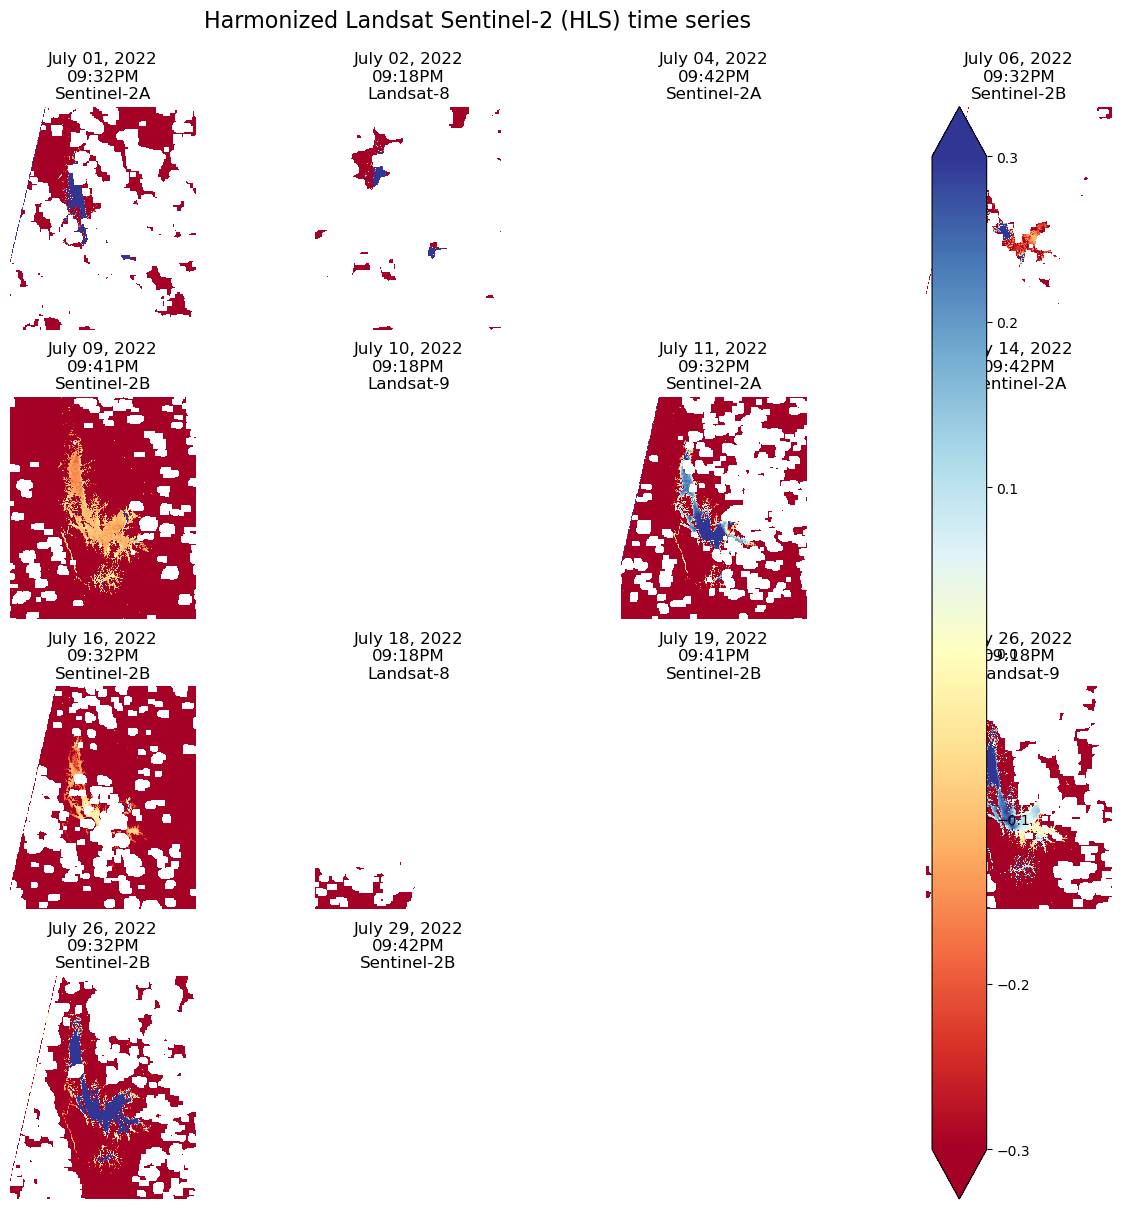

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(10, 10))

f = hls.ndwi.plot.imshow(col='time',col_wrap=4,robust=True, cmap='RdYlBu', vmax=0.3)

for ax, time, platform in zip(f.axes.flat, hls.ndwi.time.values, hls.ndwi.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

/tmp/ipykernel_4067583/2768112220.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, time, platform in zip(f.axes.flat, hls.rgb.time.values, hls.rgb.platform.values):


Text(0.5, 1.04, 'Harmonized Landsat Sentinel-2 (HLS) time series')

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


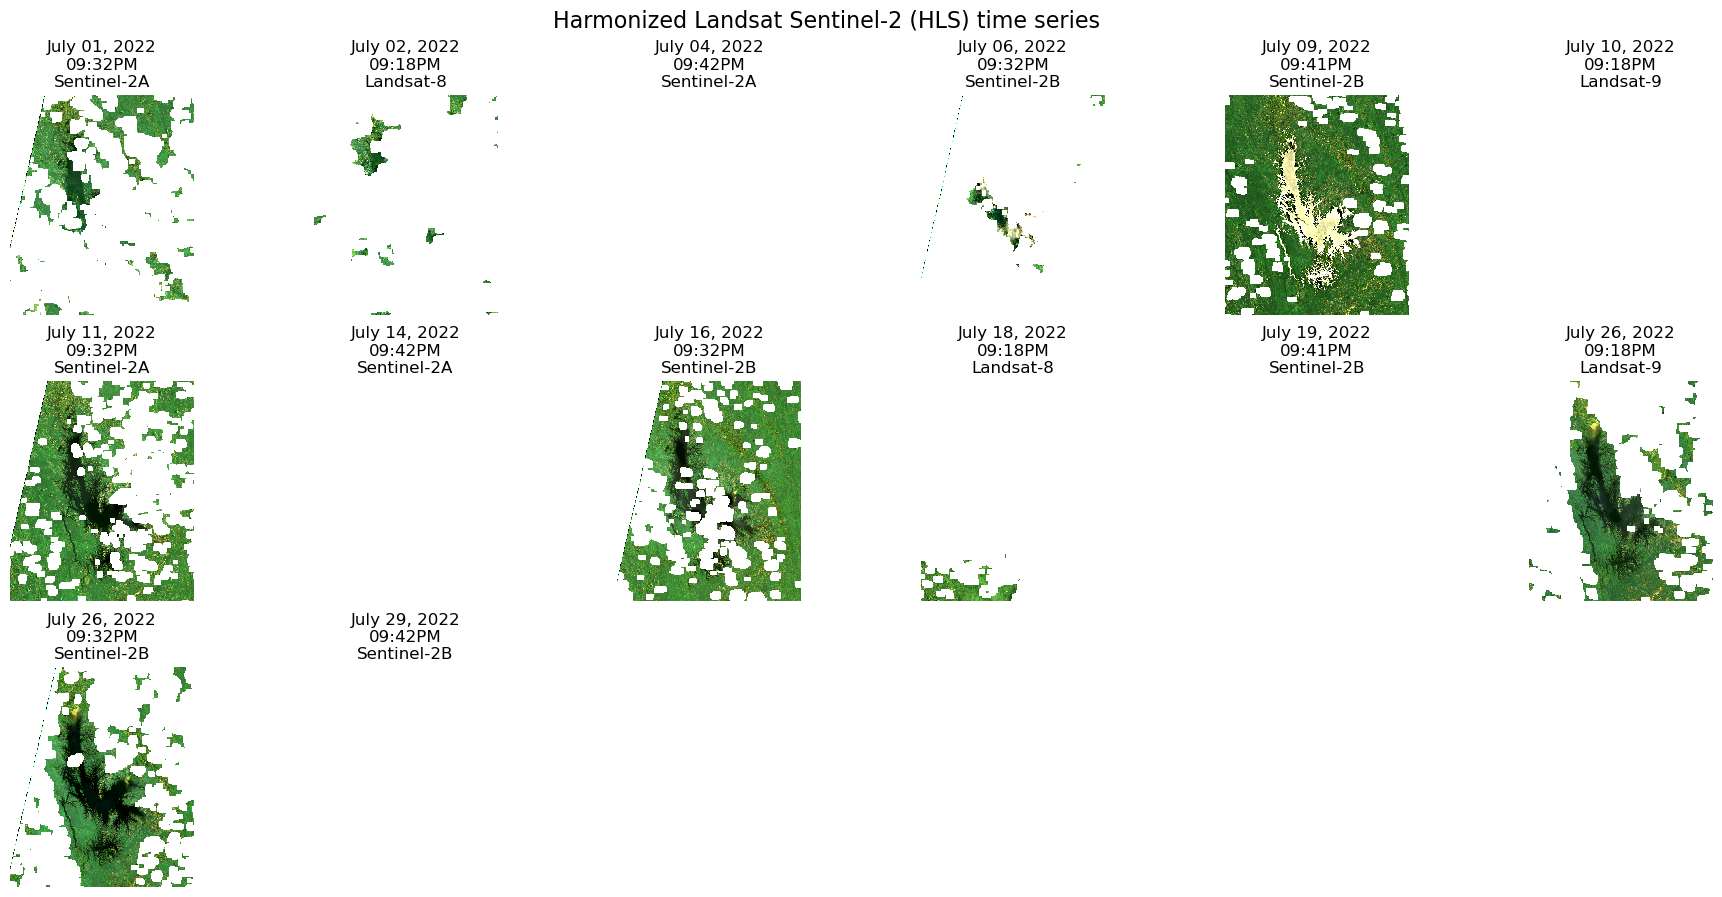

In [ ]:
f = hls.rgb.plot.imshow(col='time',col_wrap=6,robust=True)

for ax, time, platform in zip(f.axes.flat, hls.rgb.time.values, hls.rgb.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

## manually try to fix the hls access issue

In [13]:
import pystac_client

catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")
catalog

<Client id=LPCLOUD>

In [33]:
band_info = {
            "coastal aerosol": {
                "landsat_band": "B01",
                "sentinel_band": "B01",
                "description": "430-450 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "blue": {
                "landsat_band": "B02",
                "sentinel_band": "B02",
                "description": "450-510 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "green": {
                "landsat_band": "B03",
                "sentinel_band": "B03",
                "description": "530-590 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red": {
                "landsat_band": "B04",
                "sentinel_band": "B04",
                "description": "640-670 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red-edge 1": {
                "landsat_band": "-",
                "sentinel_band": "B05",
                "description": "690-710 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red-edge 2": {
                "landsat_band": "-",
                "sentinel_band": "B06",
                "description": "730-750 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red-edge 3": {
                "landsat_band": "-",
                "sentinel_band": "B07",
                "description": "770-790 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "nir broad": {
                "landsat_band": "-",
                "sentinel_band": "B08",
                "description": "780-880 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "nir narrow": {
                "landsat_band": "B05",
                "sentinel_band": "B8A",
                "description": "850-880 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "swir 1": {
                "landsat_band": "B06",
                "sentinel_band": "B11",
                "description": "1570-1650 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "swir 2": {
                "landsat_band": "B07",
                "sentinel_band": "B12",
                "description": "2110-2290 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "water vapor": {
                "landsat_band": "-",
                "sentinel_band": "B09",
                "description": "930-950 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "cirrus": {
                "landsat_band": "B09",
                "sentinel_band": "B10",
                "description": "1360-1380 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "thermal infrared 1": {
                "landsat_band": "B10",
                "sentinel_band": "-",
                "description": "10600-11190 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "thermal": {
                "landsat_band": "B11",
                "sentinel_band": "-",
                "description": "11500-12510 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "Fmask": {
                "landsat_band": "Fmask",
                "sentinel_band": "Fmask",
                "description": "quality bits",
                "data_type": "uint8",
                "nodata": "255",
                "scale": "1",
            },
            "SZA": {
                "landsat_band": "SZA",
                "sentinel_band": "SZA",
                "description": "Sun zenith degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
            "SAA": {
                "landsat_band": "SAA",
                "sentinel_band": "SAA",
                "description": "Sun azimuth degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
            "VZA": {
                "landsat_band": "VZA",
                "sentinel_band": "VZA",
                "description": "View zenith degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
            "VAA": {
                "landsat_band": "VAA",
                "sentinel_band": "VAA",
                "description": "View azimuth degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
        }

In [44]:
landsat_search = catalog.search(
            collections=["HLSL30.v2.0"],
            bbox=dumboor_buffered.total_bounds,
            datetime=("2022-07-01", "2022-07-31"),
)

import odc.stac
from easysnowdata.utils import get_stac_cfg

l8_30 = odc.stac.load(
    items = landsat_search.item_collection(),
    bbox = dumboor_buffered.total_bounds,
    chunks = {"time": 1, "x": 512, "y": 512},
    crs = dumboor_buffered.crs,
    resolution = 30,
    # groupby = "solar_day",
    bands = None, #[b for b in band_info.keys() if '-' not in b],
    stac_cfg = get_stac_cfg(sensor="HLSL30.v2.0")
)
l8_30

dumboor_buffered.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [118]:
# hls.mask_data()

In [76]:
from easysnowdata.utils import get_stac_cfg

In [100]:
band_info = {
            "coastal aerosol": {
                "landsat_band": "B01",
                "sentinel_band": "B01",
                "description": "430-450 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "blue": {
                "landsat_band": "B02",
                "sentinel_band": "B02",
                "description": "450-510 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "green": {
                "landsat_band": "B03",
                "sentinel_band": "B03",
                "description": "530-590 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red": {
                "landsat_band": "B04",
                "sentinel_band": "B04",
                "description": "640-670 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red-edge 1": {
                "landsat_band": "-",
                "sentinel_band": "B05",
                "description": "690-710 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red-edge 2": {
                "landsat_band": "-",
                "sentinel_band": "B06",
                "description": "730-750 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "red-edge 3": {
                "landsat_band": "-",
                "sentinel_band": "B07",
                "description": "770-790 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "nir broad": {
                "landsat_band": "-",
                "sentinel_band": "B08",
                "description": "780-880 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "nir narrow": {
                "landsat_band": "B05",
                "sentinel_band": "B8A",
                "description": "850-880 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "swir 1": {
                "landsat_band": "B06",
                "sentinel_band": "B11",
                "description": "1570-1650 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "swir 2": {
                "landsat_band": "B07",
                "sentinel_band": "B12",
                "description": "2110-2290 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "water vapor": {
                "landsat_band": "-",
                "sentinel_band": "B09",
                "description": "930-950 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "cirrus": {
                "landsat_band": "B09",
                "sentinel_band": "B10",
                "description": "1360-1380 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "thermal infrared 1": {
                "landsat_band": "B10",
                "sentinel_band": "-",
                "description": "10600-11190 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "thermal": {
                "landsat_band": "B11",
                "sentinel_band": "-",
                "description": "11500-12510 nm",
                "data_type": "int16",
                "nodata": "-9999",
                "scale": "0.0001",
            },
            "Fmask": {
                "landsat_band": "Fmask",
                "sentinel_band": "Fmask",
                "description": "quality bits",
                "data_type": "uint8",
                "nodata": "255",
                "scale": "1",
            },
            "SZA": {
                "landsat_band": "SZA",
                "sentinel_band": "SZA",
                "description": "Sun zenith degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
            "SAA": {
                "landsat_band": "SAA",
                "sentinel_band": "SAA",
                "description": "Sun azimuth degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
            "VZA": {
                "landsat_band": "VZA",
                "sentinel_band": "VZA",
                "description": "View zenith degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
            "VAA": {
                "landsat_band": "VAA",
                "sentinel_band": "VAA",
                "description": "View azimuth degrees",
                "data_type": "uint16",
                "nodata": "40000",
                "scale": "0.01",
            },
        }

In [106]:
bands = [band for band, info in band_info.items() if info["landsat_band"] != "-"]
bands

['coastal aerosol',
 'blue',
 'green',
 'red',
 'nir narrow',
 'swir 1',
 'swir 2',
 'cirrus',
 'thermal infrared 1',
 'thermal',
 'Fmask',
 'SZA',
 'SAA',
 'VZA',
 'VAA']

In [107]:
load_params_landsat = {
            "items": hls.search_landsat.item_collection(),
            "bbox": dumboor_buffered.total_bounds,
            "chunks": {"time": 1, "x": 512, "y": 512},
            "crs": dumboor_buffered.estimate_utm_crs(),  # maybe put 'utm'?
            "groupby": 'solar_day',
            "fail_on_error": False,
            "stac_cfg": get_stac_cfg(sensor="HLSL30.v2.0"),
            "resolution": 30,
            "bands": bands
        }
load_params_landsat

{'items': <pystac.item_collection.ItemCollection at 0x7f5a726731d0>,
 'bbox': array([91.75874684, 23.38916883, 91.9475484 , 23.59873155]),
 'chunks': {'time': 1, 'x': 512, 'y': 512},
 'crs': <Projected CRS: EPSG:32646>
 Name: WGS 84 / UTM zone 46N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.
 - bounds: (90.0, 0.0, 96.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 46N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 'groupby': 'solar_day',
 'fail_on_error': False,
 'stac_cfg': {'HLSL30.v2.0': {'assets': {'*': {'data_type': 'int16',
     'nodata': -9999,
     'scale': 0.0001},
    'Fmask': {'data_type': 'uint8', 'nodata': 255, 'scale': 1},
    'SZA': {'data_type': 'uint16', 'n

In [108]:
import odc

L30_ds = odc.stac.load(**load_params_landsat)
L30_ds

<xarray.Dataset> Size: 59MB
Dimensions:             (y: 779, x: 650, time: 4)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref         int32 4B 32646
  * time                (time) datetime64[ns] 32B 2022-07-03T04:18:29.326000 ...
Data variables: (12/15)
    coastal aerosol     (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    blue                (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    green               (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red                 (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nir narrow          (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    swir 1              (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ...                  ...
    thermal             (time, y, x) int16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    Fmask               (time, y, x) uint8 2MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SZA                 (time, y, x) uint16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SAA                 (time, y, x) uint16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    VZA                 (time, y, x) uint16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    VAA                 (time, y, x) uint16 4MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [115]:
hls.search_landsat.item_collection().get_items()

AttributeError: 'ItemCollection' object has no attribute 'get_items'

In [109]:
L30_ds.compute()

Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022208T041814.v2.0/HLS.L30.T46QCM.2022208T041814.v2.0.B11.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022192T041803.v2.0/HLS.L30.T46QCM.2022192T041803.v2.0.B11.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022200T041830.v2.0/HLS.L30.T46QCM.2022200T041830.v2.0.B10.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022200T041830.v2.0/HLS.L30.T46QCM.2022200T041830.v2.0.B11.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022208T041814.v2.0/HLS.L30.T46QCM.2022208T041814.v2.0.B11.tif:1
Ignoring read failure while reading: https://data.

<xarray.Dataset> Size: 59MB
Dimensions:             (y: 779, x: 650, time: 4)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref         int32 4B 32646
  * time                (time) datetime64[ns] 32B 2022-07-03T04:18:29.326000 ...
Data variables: (12/15)
    coastal aerosol     (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    blue                (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    green               (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    red                 (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    nir narrow          (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    swir 1              (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    ...                  ...
    thermal             (time, y, x) int16 4MB -9999 -9999 -9999 ... -9999 -9999
    Fmask               (time, y, x) uint8 2MB 255 255 255 255 ... 255 255 255
    SZA                 (time, y, x) uint16 4MB 40000 40000 ... 40000 40000
    SAA                 (time, y, x) uint16 4MB 40000 40000 ... 40000 40000
    VZA                 (time, y, x) uint16 4MB 40000 40000 ... 40000 40000
    VAA                 (time, y, x) uint16 4MB 40000 40000 ... 40000 40000

In [55]:
# from easysnowdata.remote_sensing import authenticate_all

# authenticate_all()

In [56]:
# import earthaccess

# earthaccess.login(strategy="netrc", persist=True)

In [62]:
hls.get_rgb()
# hls_rgb = hls.rgb.compute()
# hls_rgb
hls.rgb

RGB data retrieved. Access with the .rgb attribute.


<xarray.DataArray (band: 3, time: 14, y: 779, x: 650)> Size: 85MB
dask.array<stack, shape=(3, 14, 779, 650), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                          (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                          (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
    spatial_ref                int32 4B 32646
  * time                       (time) datetime64[ns] 112B 2022-07-02T04:32:12...
    platform                   (time) <U11 616B 'Sentinel-2A' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 112B 60 84 90 76 36 ... 97 63 49 92
    AssociatedBrowseImageUrls  (time) object 112B ['https://data.lpdaac.earth...
    geometry                   (time) object 112B MULTIPOLYGON (((91.7501206 ...
  * band                       (band) object 24B 'red' 'green' 'blue'

Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCL.2022184T041853.v2.0/HLS.L30.T46QCL.2022184T041853.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCL.2022191T042709.v2.0/HLS.S30.T46QCL.2022191T042709.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCL.2022208T041838.v2.0/HLS.L30.T46QCL.2022208T041838.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCL.2022188T041559.v2.0/HLS.S30.T46QCL.2022188T041559.v2.0.B02.tif:1


Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022196T042721.v2.0/HLS.S30.T46QCM.2022196T042721.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022198T041559.v2.0/HLS.S30.T46QCM.2022198T041559.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T46QCM.2022193T041601.v2.0/HLS.S30.T46QCM.2022193T041601.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022200T041830.v2.0/HLS.L30.T46QCM.2022200T041830.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T46QCM.2022200T041830.v2.0/HLS.L30.T46QCM.2022200T041830.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.

NameError: name 'pd' is not defined

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


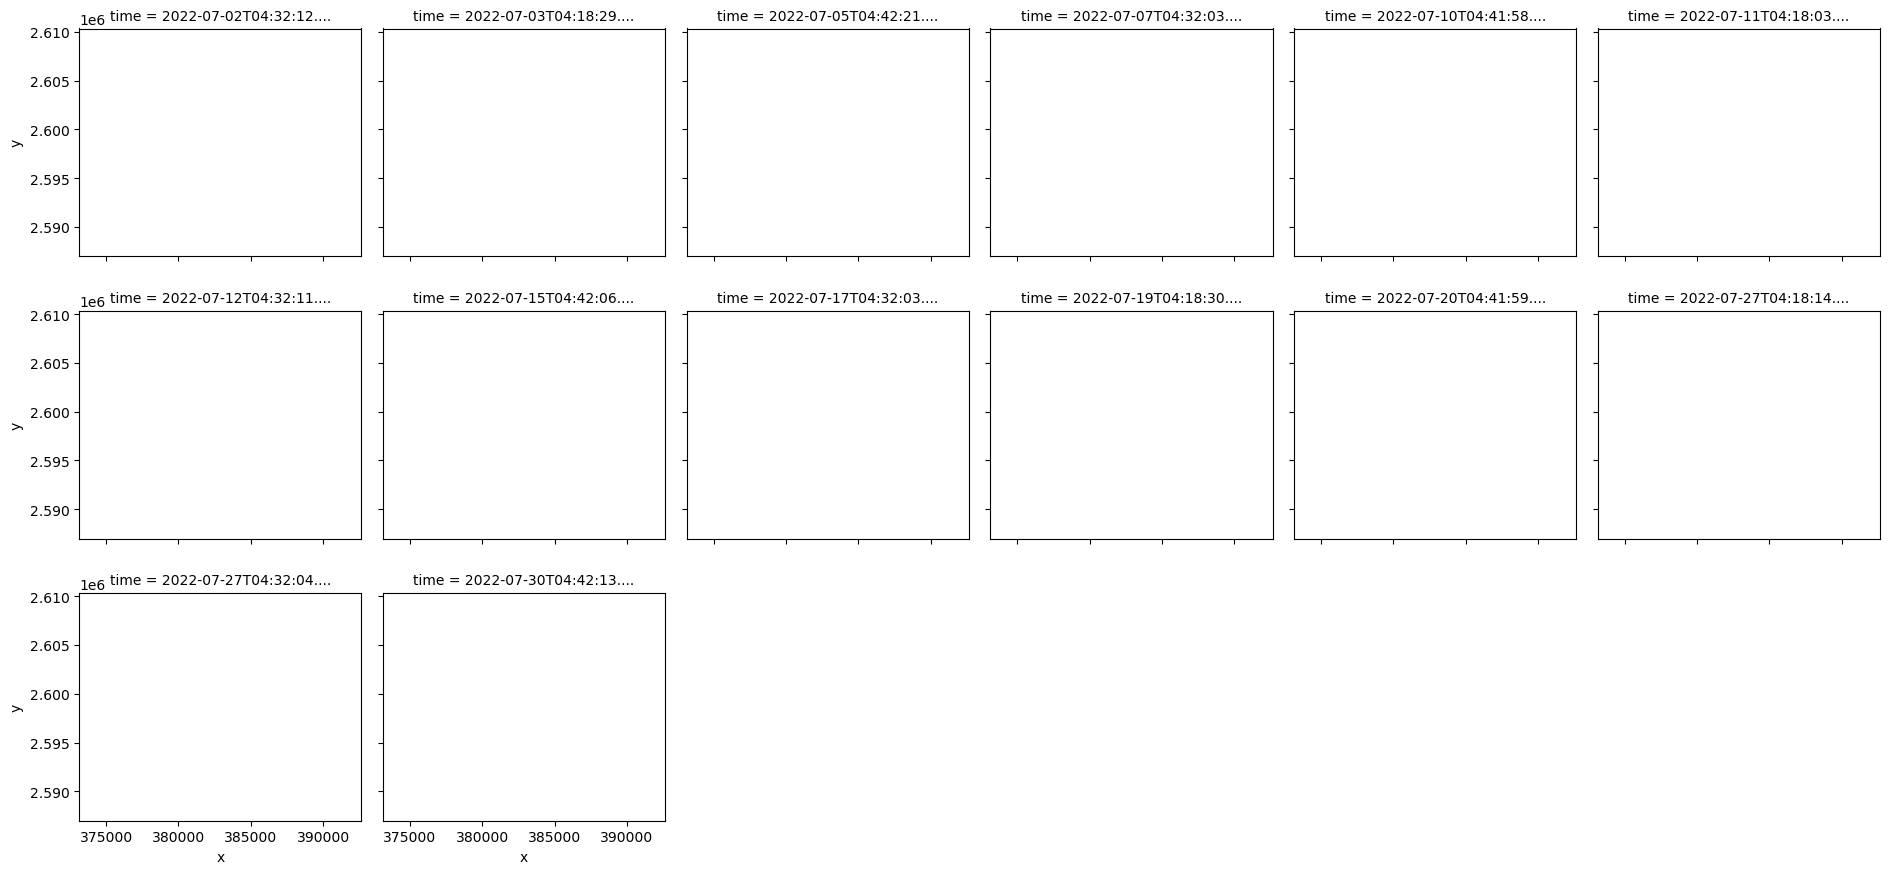

In [63]:
f = hls.rgb.plot.imshow(col='time',col_wrap=6,robust=True)

for ax, time, platform in zip(f.axes.flat, hls.rgb.time.values, hls.rgb.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime("%B %d, %Y")}\n{local_time.strftime("%I:%M%p")}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

In [38]:
hls.get_ndwi()
hls_ndwi = hls.ndwi.compute()
hls_ndwi

AttributeError: 'HLS' object has no attribute 'get_ndwi'

AttributeError: 'Dataset' object has no attribute 'nir'